In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import argparse
import yaml
from matplotlib import pyplot as plt
sys.path.append('../dsc/')
sys.path.append("../..")
sys.path.append("../../tslib/src/")
sys.path.append("../../tslib/")
sys.path.append(os.getcwd())
from dsc_model import DSCModel
from bert2bert import Bert2BertSynCtrl
from transformers import BertConfig
from src import tsUtils
import pandas as pd
from src.synthcontrol.syntheticControl import RobustSyntheticControl
from src.synthcontrol.multisyntheticControl import MultiRobustSyntheticControl
%load_ext autoreload
%autoreload 2

In [2]:
# Pretraining Asthma dataset
datapath = f'../datasets/asthma_placebo/'
config_path = '../exp_configs/asthma/config.yaml'
config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
op_path = f'../logs_dir/asthma_control/'
if not(os.path.exists(op_path)):
    os.mkdir(op_path)
random_seed = 0
target_index = 0
lowrank = True
device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
classes = None
config_model = BertConfig(hidden_size = config['hidden_size'],
                        num_hidden_layers = config['n_layers'],
                        num_attention_heads = config['n_heads'],
                        intermediate_size = 4*config['hidden_size'],
                        vocab_size = 0,
                        max_position_embeddings = 0,
                        output_hidden_states = True,
                        )

config_model.add_syn_ctrl_config(K=config['K'],
                                pre_int_len=config['pre_int_len'],
                                post_int_len=config['post_int_len'],
                                feature_dim=config['feature_dim'],
                                time_range=config['time_range'],
                                seq_range=config['seq_range'],
                                cont_dim=config['cont_dim'],
                                discrete_dim=config['discrete_dim'],
                                classes = classes)
model = Bert2BertSynCtrl(config_model, random_seed)
model = model.to(device)
dscmodel = DSCModel(model,
                    config,
                    op_path,
                    target_index,
                    random_seed,
                    datapath,
                    device,
                    lowrank = True,
                    classes=None)
dscmodel.pretrain(checkpoint_pretrain = None)

KeyboardInterrupt: 

In [2]:
#Finetuning Asthma dataset

interv_times = [7,15]

for interv_time in interv_times:
    datapath = f'../datasets/asthma_placebo/'
    config_path = '../exp_configs/asthma/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    model_path = f'../logs_dir/asthma_control/pretrain/model.pth'
    op_path = f'../logs_dir/asthma_control_{interv_time}/'
    if not(os.path.exists(op_path)):
        os.mkdir(op_path)
    random_seed = 0
    target_index = 0
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = True,
                        classes=None)
    dscmodel.load_model_from_checkpoint(model_path)
    dscmodel.fit(interv_time,pretrain=False)

Modifying K
Low rank conversion done
Fitting model on target unit
Iteration:0	Loss_mean:0.011390503495931625	Loss_std:0.0
Iteration:100	Loss_mean:0.0014387560904651764	Loss_std:0.0013078196057385084
Iteration:200	Loss_mean:0.0004749952741713059	Loss_std:0.0004630502512673258
Iteration:300	Loss_mean:0.0003761650508454295	Loss_std:0.0004099206307869222
Iteration:400	Loss_mean:0.00026303647181975977	Loss_std:0.00029691807450300345
Iteration:500	Loss_mean:0.0003704741684529722	Loss_std:0.0004241986922008731
Iteration:600	Loss_mean:0.00023757014528143826	Loss_std:0.0002848603761378654
Iteration:700	Loss_mean:0.00019913287248527923	Loss_std:0.00023158073467474156
Iteration:800	Loss_mean:0.00016335499596607407	Loss_std:0.00018196968874149334
Iteration:900	Loss_mean:0.0001556519023824876	Loss_std:0.0001691534849499482
Iteration:1000	Loss_mean:0.00018423409510432976	Loss_std:0.00017154380536594434
Iteration:1100	Loss_mean:0.0001205886162972547	Loss_std:0.00012502412794724162
Iteration:1200	Loss

In [16]:
data_dir = f'../datasets/asthma_placebo/'
mask = np.load(data_dir+'mask.npy')
data = np.load(data_dir+'data.npy')
data[np.nonzero(mask)] = 0
prob_missing = np.sum(mask)/(data.shape[0]*data.shape[1]*data.shape[2])
prob_missing_rsc = np.sum(mask[:,:,0])/(data.shape[0]*data.shape[1])
interv = [7,15]

mrsc_preds = []
rsc_preds = []
rsc_pre_preds = []
mrsc_pre_preds = []
actual = []


for TrainingEnd in interv:
    all_observations=[]
    for i in range(data.shape[2]):
        all_observations.append(data[:,:,i])

    N = all_observations[0].shape[0] -1
    T = all_observations[0].shape[1]
    print(N,T)
    trainingDict_alls = [{} for i in range(data.shape[2])]
    testDict_alls = [{} for i in range(data.shape[2])]



    for i in range(0, N+1):
        for j in range(data.shape[2]):
            trainingDict_alls[j].update({str(i): all_observations[j][i, 0:TrainingEnd]})
            testDict_alls[j].update({str(i): all_observations[j][i, TrainingEnd:]})

    keySeriesLabel = '0'
    otherSeriesLabels = []
    for ind in range(1, N+1):
        otherSeriesLabels.append(str(ind))

    # RSC analysis
    singvals = 10
    train_DF_alls = []
    test_DF_alls = []
    for j in range(data.shape[2]):
        train_DF_alls.append(pd.DataFrame(data=trainingDict_alls[j]))
        test_DF_alls.append(pd.DataFrame(data=testDict_alls[j]))


    rscmodel = RobustSyntheticControl(keySeriesLabel, singvals, len(train_DF_alls[0]), probObservation=1-prob_missing_rsc, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)
    rscmodel.fit(train_DF_alls[0])
    predictionsRSC = rscmodel.predict(test_DF_alls[0])
    rscRMSE = np.sqrt(np.mean(((predictionsRSC - test_DF_alls[0][keySeriesLabel])*(1-mask[0,TrainingEnd:,0]))**2))

    ############################
    ####  multi RSC model (combined) --
    relative_weights = [1.0 for i in range(data.shape[2])]

    # instantiate the model
    mrscmodel = MultiRobustSyntheticControl(data.shape[2], relative_weights, keySeriesLabel, singvals, len(train_DF_alls[0]), probObservation=1-prob_missing, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

    # fit
    mrscmodel.fit([train_DF_alls[i] for i in range(data.shape[2])])

    # predict
    combinedPredictionsArray = mrscmodel.predict([test_DF_alls[i] for i in range(data.shape[2])])

    # split the predictions for the metrics
    predictionsmRSC = combinedPredictionsArray[0]
    mrscRMSE = np.sqrt(np.mean(((predictionsmRSC - test_DF_alls[0][keySeriesLabel])*(1-mask[0,TrainingEnd:,0]))**2))
    op_dir = f'../logs_dir/asthma_control_{TrainingEnd}/'
    np.save(op_dir+'mrsc_pred.npy',predictionsmRSC)
    np.save(op_dir+'rsc_pred.npy',predictionsRSC)
    mrsc_preds.append(predictionsmRSC)
    rsc_preds.append(predictionsRSC)
    actual.append(np.append(train_DF_alls[0][keySeriesLabel],test_DF_alls[0][keySeriesLabel],axis=0))
    denoisedDF = rscmodel.model.denoisedDF()
    rsc_pre_preds.append(denoisedDF[keySeriesLabel])
    denoisedDF = mrscmodel.model.denoisedDF()
    mrsc_pre_preds.append(denoisedDF[keySeriesLabel])
    print(f'{TrainingEnd}:',rscRMSE,mrscRMSE)

274 20
7: 0.26622722194286425 0.34247275327138244
274 20
15: 0.3300635102270671 0.3903287941602291


In [17]:
#Predicting Asthma dataset
data_dir = f'../datasets/asthma_placebo/'
interv_times = [7,15]
mask = np.load(data_dir+'mask.npy')
data = np.load(data_dir+'data.npy')
dsc_preds = []

for interv_time in interv_times:
    datapath = f'../datasets/asthma_placebo/'
    config_path = '../exp_configs/asthma/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    model_path = f'../logs_dir/asthma_control_{interv_time}/finetune/model.pth'
    op_path = f'../logs_dir/asthma_control_{interv_time}/'
    if not(os.path.exists(op_path)):
        os.mkdir(op_path)
    random_seed = 0
    target_index = 0
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = True,
                        classes=None)
    dscmodel.load_model_from_checkpoint(model_path)
    op= dscmodel.predict(interv_time)
    ctrl  = data[0,interv_time:,0]
    pred = op[interv_time:]
    dsc_rmse = np.sqrt(np.mean(((pred -ctrl)*(1-mask[0,interv_time:,0]))**2))
    print(dsc_rmse)
    dsc_preds.append(op)

Modifying K
Low rank conversion done
0.0865168552956678
Modifying K
Low rank conversion done
0.054346473580667624


In [18]:
mc_nnm_all = []
mc_nnm7 = pd.read_csv('../datasets/asthma_7/mc_nnm_pred.csv', sep=',',header=None)
mc_nnm7 = mc_nnm7.to_numpy()[1:,].reshape(-1).astype('float32')
mc_nnm_all.append(mc_nnm7)
mc_nnm15 = pd.read_csv('../datasets/asthma_15/mc_nnm_pred.csv', sep=',',header=None)
mc_nnm15 = mc_nnm15.to_numpy()[1:,].reshape(-1).astype('float32')
mc_nnm_all.append(mc_nnm15)

(20,)
0.0876720101949723
(20,)
0.06416561062360086


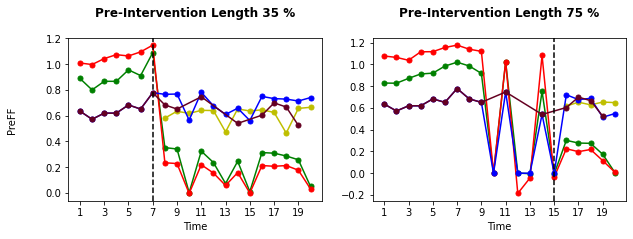

In [20]:
interv_times=[7,15]
fig, big_axes = plt.subplots(figsize=(10,3) , nrows=1, ncols=2, sharey=True) 
for title, big_ax in zip(['Pre-Intervention Length 35 %','Pre-Intervention Length 75 %'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')


for i in range(2):
    x_full = np.arange(20)+1
    mrsc_all = np.append(mrsc_pre_preds[i][:interv_times[i]],mrsc_preds[i],axis=0)
    print(mrsc_all.shape)
    rsc_all = np.append(rsc_pre_preds[i],rsc_preds[i],axis=0)
    mask_this =(1-mask[0,:,0])>0
    x = x_full[mask_this]
    xint = [i for i in range(1,20,2)]
    xlabels = [str(i) for i in range(1,20,2)]
    a=fig.add_subplot(1,2,i+1)
    a.set_xticks(xint,minor=False)
    a.plot(x_full,rsc_all,'og-',label='RSC',markersize=5)
    a.plot(x_full,mrsc_all,'or-',label='mRSC',markersize=5)
    if interv_times[i] == 7:
        x_mcnnm = x_full[-13:]
        mcnnm = np.flip(mc_nnm_all[i])[-13:]
    else:
        x_mcnnm = x_full[-5:]
        mcnnm = np.flip(mc_nnm_all[i])[-5:]
    ctrl  = data[0,interv_times[i]:,0]
    print(np.sqrt(np.mean(((mcnnm -ctrl)*(1-mask[0,interv_times[i]:,0]))**2)))
    a.plot(x_mcnnm,mcnnm,'oy-',label='MC-NNM',markersize=5)
    a.plot(x_full,dsc_preds[i],'ob-',label='Ours',markersize=5)
    a.plot(x,actual[i][mask_this],'xkcd:maroon',marker='o',label='Observed Control',markersize=5)
   
   
    plt.axvline(x =interv_times[i],ymin=0, ymax =1 ,linestyle='--',color='black')
    
    #a.legend(loc='upper right')
    a.set_xlabel('Time')
    #a.legend(ncol=4,bbox_to_anchor=(0.5,1), loc = 'lower center')
    
fig.text(0.04, 0.5, 'PreFF', va='center', rotation='vertical')
handles, labels = a.get_legend_handles_labels()
# fig.legend(handles, labels, ncol=5,loc='lower center',bbox_to_anchor=(0.5,-0.15))
plt.savefig(f'./figs/asthma.png',bbox_inches='tight')

In [17]:
# Pretraining Asthma dataset for patient i

for i in range(4):
    datapath = f'../datasets/asthma_placebo/'
    config_path = '../exp_configs/asthma/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/asthma_control_7_{i+1}/'
    if not(os.path.exists(op_path)):
        os.mkdir(op_path)
    random_seed = 0
    target_index = i+1
    interv_time = 7
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = True,
                        classes=None)
    dscmodel.pretrain(checkpoint_pretrain = None)
    dscmodel.fit(interv_time,pretrain=False)

Low rank conversion done
Pretraining model on donor units
Iteration:0	Loss_mean:0.3994048237800598	Loss_std:0.0
Iteration:100	Loss_mean:0.50843164117774	Loss_std:0.6121105396271254
Iteration:200	Loss_mean:0.4417340673785657	Loss_std:0.5235069540510024
Iteration:300	Loss_mean:0.35787467050126	Loss_std:0.39937001339768974
Iteration:400	Loss_mean:0.32332832747895734	Loss_std:0.3200453105043522
Iteration:500	Loss_mean:0.29899597238283604	Loss_std:0.306728463242718
Iteration:600	Loss_mean:0.2781198068126105	Loss_std:0.27321830687963006
Iteration:700	Loss_mean:0.20839264482085126	Loss_std:0.20851790821415112
Iteration:800	Loss_mean:0.19879733559292959	Loss_std:0.22553297124179353
Iteration:900	Loss_mean:0.17156928835807775	Loss_std:0.14729015874114754
Iteration:1000	Loss_mean:0.1188106740260264	Loss_std:0.13219879108029498
Iteration:1100	Loss_mean:0.16089216780557763	Loss_std:0.17348159081108916
Iteration:1200	Loss_mean:0.12869126065052114	Loss_std:0.11431081142713306
Iteration:1300	Loss_mea

Iteration:1000	Loss_mean:0.00022244289772544335	Loss_std:0.00020982661317036448
Iteration:1100	Loss_mean:0.00022923706716028393	Loss_std:0.00024513359405530633
Iteration:1200	Loss_mean:0.0002452449216707464	Loss_std:0.000332835157930842
Iteration:1300	Loss_mean:0.00016541357913865795	Loss_std:0.0002024995565313412
Iteration:1400	Loss_mean:0.00016296922586548135	Loss_std:0.00015273063257974427
Iteration:1500	Loss_mean:0.00017802636841111053	Loss_std:0.0001876364960904159
Iteration:1600	Loss_mean:0.000154031538761501	Loss_std:0.0001603731868215441
Iteration:1700	Loss_mean:0.00015119184903142013	Loss_std:0.0001431657183528116
Iteration:1800	Loss_mean:9.518524714167143e-05	Loss_std:0.00011972725104596082
Iteration:1900	Loss_mean:0.00011069157513617256	Loss_std:0.00013155888033901074
Iteration:2000	Loss_mean:0.0001375385256142181	Loss_std:0.00015572210741372856
Iteration:2100	Loss_mean:0.0001377821300047799	Loss_std:0.00013147967468522318
Iteration:2200	Loss_mean:0.00025468461348054916	Loss

Iteration:6900	Loss_mean:0.048867894603754396	Loss_std:0.057653860325514776
Iteration:7000	Loss_mean:0.07203563088056399	Loss_std:0.08882223880663674
Iteration:7100	Loss_mean:0.06521251443889924	Loss_std:0.07176324644339538
Iteration:7200	Loss_mean:0.06111757532693446	Loss_std:0.07247812834111249
Iteration:7300	Loss_mean:0.04699740180061781	Loss_std:0.05918929683416378
Iteration:7400	Loss_mean:0.06037725170463091	Loss_std:0.07318167268676201
Iteration:7500	Loss_mean:0.06974688742571743	Loss_std:0.0927954433663138
Iteration:7600	Loss_mean:0.062031604633302775	Loss_std:0.06742154405080465
Iteration:7700	Loss_mean:0.06955746209947393	Loss_std:0.08897886178488436
Iteration:7800	Loss_mean:0.06090631984960055	Loss_std:0.06437620928136387
Iteration:7900	Loss_mean:0.06747903028444853	Loss_std:0.07274458844524452
Iteration:8000	Loss_mean:0.05837728620714188	Loss_std:0.07334638757755634
Iteration:8100	Loss_mean:0.051216866231989115	Loss_std:0.06545467697995372
Iteration:8200	Loss_mean:0.06386635

Iteration:2700	Loss_mean:0.08471683397423475	Loss_std:0.11149247027186183
Iteration:2800	Loss_mean:0.06525887197138218	Loss_std:0.08850515892552742
Iteration:2900	Loss_mean:0.062465703052075695	Loss_std:0.07113756181601791
Iteration:3000	Loss_mean:0.07032761256908998	Loss_std:0.09003096476692882
Iteration:3100	Loss_mean:0.07024551339716709	Loss_std:0.08470649527483924
Iteration:3200	Loss_mean:0.055487222292431394	Loss_std:0.08721669079723306
Iteration:3300	Loss_mean:0.06585440252965782	Loss_std:0.07131971743820502
Iteration:3400	Loss_mean:0.07510715188458562	Loss_std:0.0973382478487198
Iteration:3500	Loss_mean:0.07076014836551621	Loss_std:0.0840343254704317
Iteration:3600	Loss_mean:0.05040399530347713	Loss_std:0.07927046617727769
Iteration:3700	Loss_mean:0.0566358044865774	Loss_std:0.09053174278159255
Iteration:3800	Loss_mean:0.06052320155040434	Loss_std:0.07910625283869548
Iteration:3900	Loss_mean:0.06098796894715633	Loss_std:0.09043117703414326
Iteration:4000	Loss_mean:0.042510671544

Iteration:3600	Loss_mean:6.578567926908363e-05	Loss_std:6.483580574235397e-05
Iteration:3700	Loss_mean:7.702154916046311e-05	Loss_std:0.00011091910532548329
Iteration:3800	Loss_mean:5.09292594431976e-05	Loss_std:5.427673308867498e-05
Iteration:3900	Loss_mean:2.843551517248244e-05	Loss_std:2.9992428033242066e-05
Iteration:4000	Loss_mean:4.6536775212189244e-05	Loss_std:4.859046690168833e-05
Iteration:4100	Loss_mean:6.11105350088792e-05	Loss_std:5.865717225913967e-05
Iteration:4200	Loss_mean:4.5341280633834915e-05	Loss_std:4.497126402505901e-05
Iteration:4300	Loss_mean:3.071032477976132e-05	Loss_std:3.4542189073608e-05
Iteration:4400	Loss_mean:2.7796661199772644e-05	Loss_std:3.731131235439628e-05
Iteration:4500	Loss_mean:3.35688210438434e-05	Loss_std:3.6353554585261024e-05
Iteration:4600	Loss_mean:3.373414624746829e-05	Loss_std:3.4404085510542486e-05
Iteration:4700	Loss_mean:4.699132336387635e-05	Loss_std:4.386714957309829e-05
Iteration:4800	Loss_mean:5.7358013352768464e-05	Loss_std:6.101

Iteration:9600	Loss_mean:0.06183273096568882	Loss_std:0.0814405715208469
Iteration:9700	Loss_mean:0.05570344029911212	Loss_std:0.07598014141823645
Iteration:9800	Loss_mean:0.060097602739697324	Loss_std:0.07887508649418534
Iteration:9900	Loss_mean:0.06121258076347658	Loss_std:0.07806286827113955
Modifying K
Low rank conversion done
Fitting model on target unit
Iteration:0	Loss_mean:0.00566469831392169	Loss_std:0.0
Iteration:100	Loss_mean:0.0010743090606570149	Loss_std:0.0012160093875726735
Iteration:200	Loss_mean:0.0005650757829243957	Loss_std:0.0005112401296420602
Iteration:300	Loss_mean:0.0005140999107189969	Loss_std:0.0006481569763482371
Iteration:400	Loss_mean:0.00042004968579689717	Loss_std:0.0004263316187211954
Iteration:500	Loss_mean:0.0004449765230401681	Loss_std:0.000501103202601159
Iteration:600	Loss_mean:0.00030441690295901936	Loss_std:0.00030234224262575666
Iteration:700	Loss_mean:0.00024859220276994163	Loss_std:0.00027259086209504836
Iteration:800	Loss_mean:0.00017512952195

In [18]:
# Pretraining Asthma dataset for patient i

for i in range(4):
    datapath = f'../datasets/asthma_placebo/'
    config_path = '../exp_configs/asthma/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/asthma_control_15_{i+1}/'
    if not(os.path.exists(op_path)):
        os.mkdir(op_path)
    random_seed = 0
    target_index = i+1
    interv_time = 15
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = True,
                        classes=None)
    dscmodel.pretrain(checkpoint_pretrain = None)
    dscmodel.fit(interv_time,pretrain=False)

Low rank conversion done
Pretraining model on donor units
Iteration:0	Loss_mean:0.9548130035400391	Loss_std:0.0
Iteration:100	Loss_mean:0.26277202284312806	Loss_std:0.3569237859786106
Iteration:200	Loss_mean:0.205508125879569	Loss_std:0.24098625295137305
Iteration:300	Loss_mean:0.24217741135740653	Loss_std:0.32498994274125953
Iteration:400	Loss_mean:0.21309859101253095	Loss_std:0.25493614577714396
Iteration:500	Loss_mean:0.20525252724066376	Loss_std:0.25135369945333397
Iteration:600	Loss_mean:0.1903323499765247	Loss_std:0.224430846255605
Iteration:700	Loss_mean:0.20562455516308545	Loss_std:0.2451351310162738
Iteration:800	Loss_mean:0.14450661014649085	Loss_std:0.2226872479505097
Iteration:900	Loss_mean:0.16176206442993135	Loss_std:0.2124188188891478
Iteration:1000	Loss_mean:0.13812234984739916	Loss_std:0.17592154816317868
Iteration:1100	Loss_mean:0.11234676412423142	Loss_std:0.13440609691876207
Iteration:1200	Loss_mean:0.1204233621279127	Loss_std:0.17405766975952172
Iteration:1300	Loss

Iteration:1000	Loss_mean:0.0006847154607828543	Loss_std:0.0007911603559098534
Iteration:1100	Loss_mean:0.0012287969067000405	Loss_std:0.0022443209913847262
Iteration:1200	Loss_mean:0.0005503996478728368	Loss_std:0.0005458694253358614
Iteration:1300	Loss_mean:0.000858223801569693	Loss_std:0.001207448104401666
Iteration:1400	Loss_mean:0.0008837692544148013	Loss_std:0.0013635870744596495
Iteration:1500	Loss_mean:0.0006622710118608665	Loss_std:0.0007215563591084006
Iteration:1600	Loss_mean:0.0003885138968595925	Loss_std:0.00040273807283981115
Iteration:1700	Loss_mean:0.00079295425786313	Loss_std:0.0010524372143887121
Iteration:1800	Loss_mean:0.0004898209595609159	Loss_std:0.0006057016450854619
Iteration:1900	Loss_mean:0.00044176590512506664	Loss_std:0.0005185642407795431
Iteration:2000	Loss_mean:0.0005173382267321358	Loss_std:0.0006474528164667586
Iteration:2100	Loss_mean:0.0004128457737624558	Loss_std:0.0004580473756026334
Iteration:2200	Loss_mean:0.0005806835436942493	Loss_std:0.00082816

Iteration:6900	Loss_mean:0.04846483760571573	Loss_std:0.05707577371875324
Iteration:7000	Loss_mean:0.07135655631544069	Loss_std:0.08815251160589829
Iteration:7100	Loss_mean:0.0647583055353607	Loss_std:0.07107718367208142
Iteration:7200	Loss_mean:0.06073785012820736	Loss_std:0.07171132802577204
Iteration:7300	Loss_mean:0.04664675702573731	Loss_std:0.0589685970636969
Iteration:7400	Loss_mean:0.0599587986554252	Loss_std:0.07248303921663252
Iteration:7500	Loss_mean:0.06900762621924514	Loss_std:0.09229942006550952
Iteration:7600	Loss_mean:0.0612673785770312	Loss_std:0.06659629746665263
Iteration:7700	Loss_mean:0.06647609631720115	Loss_std:0.08556210929407422
Iteration:7800	Loss_mean:0.0601531917732791	Loss_std:0.0636570257167755
Iteration:7900	Loss_mean:0.06660082030037301	Loss_std:0.07163383236003976
Iteration:8000	Loss_mean:0.057051212910882894	Loss_std:0.0723243928330479
Iteration:8100	Loss_mean:0.05062180245877244	Loss_std:0.06441239534716792
Iteration:8200	Loss_mean:0.05682829401092022

Iteration:2700	Loss_mean:0.08670501198444981	Loss_std:0.11430991883512244
Iteration:2800	Loss_mean:0.0706950541162223	Loss_std:0.09439297219319784
Iteration:2900	Loss_mean:0.0652764487256718	Loss_std:0.07163553909269503
Iteration:3000	Loss_mean:0.0715152211044915	Loss_std:0.091071881069251
Iteration:3100	Loss_mean:0.07090546973297024	Loss_std:0.08574277659042155
Iteration:3200	Loss_mean:0.0587334922219452	Loss_std:0.09123467956819098
Iteration:3300	Loss_mean:0.07118235645582899	Loss_std:0.0717353274347613
Iteration:3400	Loss_mean:0.07909460691735148	Loss_std:0.09961222465152612
Iteration:3500	Loss_mean:0.07186395427037497	Loss_std:0.08248644781775588
Iteration:3600	Loss_mean:0.05243948330211424	Loss_std:0.08138066104361814
Iteration:3700	Loss_mean:0.057424811364908235	Loss_std:0.09238248138955285
Iteration:3800	Loss_mean:0.06186898307845695	Loss_std:0.08016722317996605
Iteration:3900	Loss_mean:0.06264512017020024	Loss_std:0.09375902250634166
Iteration:4000	Loss_mean:0.04349482714038458

Iteration:3600	Loss_mean:0.0003711280816605722	Loss_std:0.0004459910370890564
Iteration:3700	Loss_mean:0.0009893715787984547	Loss_std:0.0012357690741184961
Iteration:3800	Loss_mean:0.001063061527092941	Loss_std:0.0013542014713590347
Iteration:3900	Loss_mean:0.0006189687812366174	Loss_std:0.0009528383991048228
Iteration:4000	Loss_mean:0.000413441443965894	Loss_std:0.0005040565457066835
Iteration:4100	Loss_mean:0.0006711218635109617	Loss_std:0.0010679771139880025
Iteration:4200	Loss_mean:0.00040325921161183943	Loss_std:0.0004346292740247235
Iteration:4300	Loss_mean:0.000499129183272089	Loss_std:0.000659674349444872
Iteration:4400	Loss_mean:0.00037090681787731227	Loss_std:0.0003444435033119796
Iteration:4500	Loss_mean:0.0004497150317800802	Loss_std:0.0005912511270978867
Iteration:4600	Loss_mean:0.0005409814215840925	Loss_std:0.0006683374911497932
Iteration:4700	Loss_mean:0.0002431319261927456	Loss_std:0.0003186770393935711
Iteration:4800	Loss_mean:0.00040113654960691745	Loss_std:0.0005173

In [4]:
#Predicting Asthma dataset

interv_times = [7,15]
data_dir = f'../datasets/asthma_placebo/'
mask = np.load(data_dir+'mask.npy')
data = np.load(data_dir+'data.npy')
dsc_preds = []

for interv_time in interv_times:
    for i in range(4):
        datapath = f'../datasets/asthma_placebo/'
        config_path = '../exp_configs/asthma/config.yaml'
        config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
        model_path = f'../logs_dir/asthma_control_{interv_time}_{i+1}/finetune/model.pth'
        op_path = f'../logs_dir/asthma_{interv_time}_{i+1}/'
        if not(os.path.exists(op_path)):
            os.mkdir(op_path)
        random_seed = 0
        target_index = i+1
        lowrank = True
        device = torch.device( "cpu")
        classes = None
        config_model = BertConfig(hidden_size = config['hidden_size'],
                                num_hidden_layers = config['n_layers'],
                                num_attention_heads = config['n_heads'],
                                intermediate_size = 4*config['hidden_size'],
                                vocab_size = 0,
                                max_position_embeddings = 0,
                                output_hidden_states = True,
                                )

        config_model.add_syn_ctrl_config(K=config['K'],
                                        pre_int_len=config['pre_int_len'],
                                        post_int_len=config['post_int_len'],
                                        feature_dim=config['feature_dim'],
                                        time_range=config['time_range'],
                                        seq_range=config['seq_range'],
                                        cont_dim=config['cont_dim'],
                                        discrete_dim=config['discrete_dim'],
                                        classes = classes)
        model = Bert2BertSynCtrl(config_model, random_seed)
        model = model.to(device)
        dscmodel = DSCModel(model,
                            config,
                            op_path,
                            target_index,
                            random_seed,
                            datapath,
                            device,
                            lowrank = True,
                            classes=None)
        dscmodel.load_model_from_checkpoint(model_path)
        op= dscmodel.predict(interv_time)
        ctrl  = data[i+1,interv_time:,0]
        pred = op[interv_time:]
        np.save(f'../datasets/asthma_{interv_time}_{i+1}/'+'ours_pred.npy',op)
        dsc_rmse = np.sqrt(np.mean(((pred -ctrl)*(1-mask[i+1,interv_time:,0]))**2))
        print(np.sum(1-mask[i+1,interv_time:,0]))
        print(f'RMSE for {interv_time} and id  {i+1} is',dsc_rmse)
        dsc_preds.append(op)

Modifying K
Low rank conversion done
9
RMSE for 7 and id  1 is 0.03568497953129439
Modifying K
Low rank conversion done
9
RMSE for 7 and id  2 is 0.0867707108995796
Modifying K
Low rank conversion done
3
RMSE for 7 and id  3 is 0.07236631719232979
Modifying K
Low rank conversion done
8
RMSE for 7 and id  4 is 0.03632251500102981
Modifying K
Low rank conversion done
4
RMSE for 15 and id  1 is 0.056386377486719576
Modifying K
Low rank conversion done
4
RMSE for 15 and id  2 is 0.062150809387791196
Modifying K
Low rank conversion done
0
RMSE for 15 and id  3 is 0.0
Modifying K
Low rank conversion done
4
RMSE for 15 and id  4 is 0.09982178624356958


In [5]:
interv_times = [7,15]
for interv_time in interv_times:
    for i in range(4):
        ctrl  = data[i+1,interv_time:,0]
        mc_nnm = pd.read_csv(f'../datasets/asthma_{interv_time}_{i+1}/mc_nnm_pred.csv', sep=',',header=None)
        mc_nnm = mc_nnm.to_numpy()[1:,].reshape(-1).astype('float32')
        mcnnm_rmse = np.sqrt(np.mean(((mc_nnm -ctrl)*(1-mask[i+1,interv_time:,0]))**2))
        print(f'RMSE for {interv_time} and id  {i+1} is',mcnnm_rmse)
       

RMSE for 7 and id  1 is 0.06864432031629517
RMSE for 7 and id  2 is 0.03552544992679804
RMSE for 7 and id  3 is 0.09766559060762015
RMSE for 7 and id  4 is 0.0331876037211078
RMSE for 15 and id  1 is 0.10594352426565229
RMSE for 15 and id  2 is 0.04150717437442029
RMSE for 15 and id  3 is 0.0
RMSE for 15 and id  4 is 0.017720479782479176


In [6]:
data_dir = f'../datasets/asthma_placebo/'
mask = np.load(data_dir+'mask.npy')
data = np.load(data_dir+'data.npy')
data[np.nonzero(mask)] = 0
prob_missing = np.sum(mask)/(data.shape[0]*data.shape[1]*data.shape[2])
prob_missing_rsc = np.sum(mask[:,:,0])/(data.shape[0]*data.shape[1])
interv = [7,15]




for TrainingEnd in interv:
    for id in range(4):
        
        all_observations=[]
        for i in range(data.shape[2]):
            all_observations.append(data[:,:,i])

        N = all_observations[0].shape[0] -1
        T = all_observations[0].shape[1]
#         print(N,T)
        trainingDict_alls = [{} for i in range(data.shape[2])]
        testDict_alls = [{} for i in range(data.shape[2])]



        for i in range(0, N+1):
            for j in range(data.shape[2]):
                trainingDict_alls[j].update({str(i): all_observations[j][i, 0:TrainingEnd]})
                testDict_alls[j].update({str(i): all_observations[j][i, TrainingEnd:]})

        keySeriesLabel = f'{id+1}'
        otherSeriesLabels = []
        for ind in range(N+1):
            if ind != id+1:
                otherSeriesLabels.append(str(ind))

        # RSC analysis
        singvals = 10
        train_DF_alls = []
        test_DF_alls = []
        for j in range(data.shape[2]):
            train_DF_alls.append(pd.DataFrame(data=trainingDict_alls[j]))
            test_DF_alls.append(pd.DataFrame(data=testDict_alls[j]))


        rscmodel = RobustSyntheticControl(keySeriesLabel, singvals, len(train_DF_alls[0]), probObservation=1-prob_missing_rsc, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)
        rscmodel.fit(train_DF_alls[0])
        predictionsRSC = rscmodel.predict(test_DF_alls[0])
        rscRMSE = np.sqrt(np.mean(((predictionsRSC - test_DF_alls[0][keySeriesLabel])*(1-mask[id+1,TrainingEnd:,0]))**2))

        ############################
        ####  multi RSC model (combined) --
        relative_weights = [1.0 for i in range(data.shape[2])]

        # instantiate the model
        mrscmodel = MultiRobustSyntheticControl(data.shape[2], relative_weights, keySeriesLabel, singvals, len(train_DF_alls[0]), probObservation=1-prob_missing, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

        # fit
        mrscmodel.fit([train_DF_alls[i] for i in range(data.shape[2])])

        # predict
        combinedPredictionsArray = mrscmodel.predict([test_DF_alls[i] for i in range(data.shape[2])])

        # split the predictions for the metrics
        predictionsmRSC = combinedPredictionsArray[0]
        mrscRMSE = np.sqrt(np.mean(((predictionsmRSC - test_DF_alls[0][keySeriesLabel])*(1-mask[id+1,TrainingEnd:,0]))**2))
        denoisedDF = rscmodel.model.denoisedDF()
        rsc_pre_preds = denoisedDF[keySeriesLabel]
        denoisedDF = mrscmodel.model.denoisedDF()
        mrsc_pre_preds = denoisedDF[keySeriesLabel]
        mrsc_pre_preds = mrsc_pre_preds[:TrainingEnd]
        np.save(f'../datasets/asthma_{TrainingEnd}_{id+1}/'+'mrsc_pred.npy',np.concatenate((mrsc_pre_preds,predictionsmRSC)))
        np.save(f'../datasets/asthma_{TrainingEnd}_{id+1}/'+'rsc_pred.npy',np.concatenate((rsc_pre_preds,predictionsRSC)))
        print(f'{TrainingEnd} {id+1}:',rscRMSE,mrscRMSE)

7 1: 0.25970170439664275 0.31424202064348983
7 2: 0.2904385086320537 0.34516483482509863
7 3: 0.281947026385052 0.3158331364239833
7 4: 0.2853988840709961 0.3505889088100887
15 1: 0.23980517090964462 0.3099057572568129
15 2: 0.27834436984302835 0.349427494050227
15 3: 0.0 0.0
15 4: 0.41025727001232704 0.4780634323923235


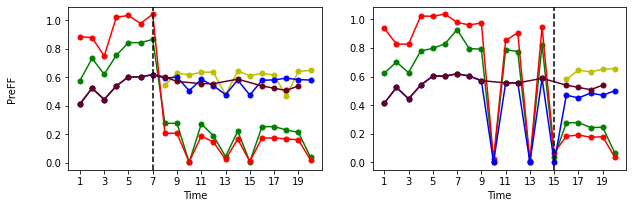

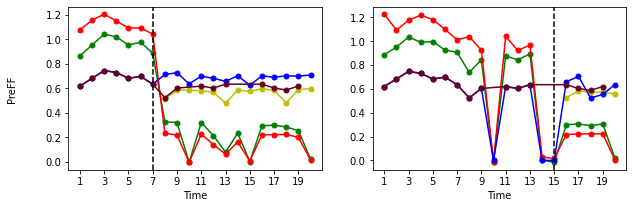

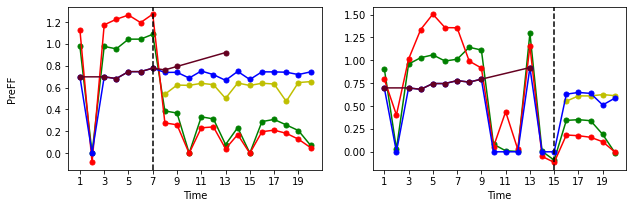

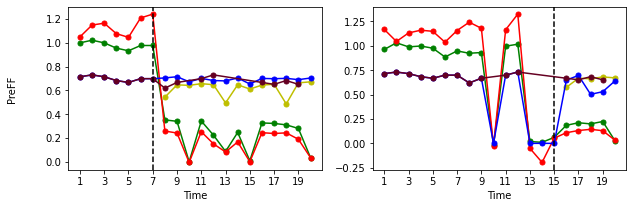

In [22]:
interv_times=[7,15]


for id in range(4):
    
    pl = 0
    fig, big_axes = plt.subplots(figsize=(10,3) , nrows=1, ncols=2, sharey=True) 
    for title, big_ax in zip(['Pre-Intervention Length 35 %','Pre-Intervention Length 75 %'], big_axes):
#         big_ax.set_title(f'{title}\n', fontweight='semibold')
        big_ax.set_frame_on(False)
        big_ax.axis('off')
    for interv_time in interv_times:
        x_full = np.arange(20)+1
        data_path = f'../datasets/asthma_{interv_time}_{id+1}/'
        mrsc_pred = np.load(data_path+'/mrsc_pred.npy')
        rsc_pred = np.load(data_path+'/rsc_pred.npy')
        ours =  np.load(data_path+'/ours_pred.npy')
        mc_nnm = pd.read_csv(f'../datasets/asthma_{interv_time}_{id+1}/mc_nnm_pred.csv', sep=',',header=None)
        mc_nnm = mc_nnm.to_numpy()[1:,].reshape(-1).astype('float32')
        mask_this =(1-mask[id+1,:,0])>0
        x = x_full[mask_this]
        xint = [i for i in range(1,20,2)]
        xlabels = [str(i) for i in range(1,20,2)]
        a=fig.add_subplot(1,2,pl+1)
        a.set_xticks(xint,minor=False)
        a.plot(x_full,rsc_pred,'og-',label='RSC',markersize=5)
        a.plot(x_full,mrsc_pred,'or-',label='mRSC',markersize=5)
        if interv_time == 7:
            x_mcnnm = x_full[-13:]
            mcnnm = np.flip(mc_nnm)[-13:]
        else:
            x_mcnnm = x_full[-5:]
            mcnnm = np.flip(mc_nnm)[-5:]
        obs = data[id+1,:,0]
        a.plot(x_mcnnm,mcnnm,'oy-',label='MC-NNM',markersize=5)
        a.plot(x_full,ours,'ob-',label='Ours',markersize=5)
        a.plot(x,obs[mask_this],'xkcd:maroon',marker='o',label='Observed Control',markersize=5)


        plt.axvline(x =interv_time,ymin=0, ymax =1 ,linestyle='--',color='black')

        #a.legend(loc='upper right')
        a.set_xlabel('Time')
        #a.legend(ncol=4,bbox_to_anchor=(0.5,1), loc = 'lower center')
        pl+=1

    fig.text(0.04, 0.5, 'PreFF', va='center', rotation='vertical')
    handles, labels = a.get_legend_handles_labels()
#     fig.legend(handles, labels, ncol=5,loc='lower center',bbox_to_anchor=(0.5,-0.15))
    plt.savefig(f'./figs/asthma.pdf',bbox_inches='tight')